# STEP : Rarefaction Analysis

Using QIIME2 to create rarefaction graphs.


## Methods
[qiime alpha_rarefaction](https://docs.qiime2.org/2023.2/plugins/available/diversity/alpha-rarefaction/)
```
Generate interactive alpha rarefaction curves by computing rarefactions
between `min_depth` and `max_depth`. The number of intermediate depths to
compute is controlled by the `steps` parameter, with n `iterations` being
computed at each rarefaction depth. If sample metadata is provided, samples
may be grouped based on distinct values within a metadata column.
```


## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [4]:
# Parameters
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-thayane"
class_col = "above_10"
classifier_file = (
    "/home/lauro/nupeb/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
)
experiment_name = "thayane-PM-paired-end-trim-overlap-04"
manifest_file = (
    "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/manifest-paired.csv"
)
metadata_file = (
    "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/paired-end-metadata.tsv"
)
overlap = 4
phred = 20
replace_files = False
threads = 6
trim = {
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "overlap": 8,
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}
trunc_f = 0
trunc_r = 0


### Defining names, paths and flags

In [5]:
# Experiments
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
!mkdir -p {experiment_folder}

# Imgs folder
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
!mkdir -p {img_folder}

# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
!mkdir -p {qiime_folder}

In [6]:
# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Output -Rarefaction Artifacts
alpha_rarefaction_path = os.path.join(qiime_folder, 'alpha-rarefaction.qza')
alpha_rarefaction_view_path = os.path.join(qiime_folder, 'alpha-rarefaction.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(alpha_rarefaction_path)) or replace_files
need_view = not (os.path.isfile(alpha_rarefaction_view_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
#Load Metadata
metadata_qa = Metadata.load(metadata_file)

In [8]:
alt_tab_path = os.path.join(base_dir, 'data', 'interim', 'dada2-tabs.qza')
# Verify if table file exists and if it is shared
if not os.path.isfile(dada2_tabs_path) and os.path.isfile(alt_tab_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_tab_path, dada2_tabs_path)

In [9]:
# Load Table artifact
tabs = Artifact.load(dada2_tabs_path)
# Filter samples using Metadata IDs
tabs = filter_samples(
    table=tabs,
    metadata=metadata_qa,
).filtered_table
tabs_df = tabs.view(Metadata).to_dataframe().T

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
38 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
38 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnP

## Alpha Rarefaction

In [10]:
# Get min and maximum feature counts to set sampling depth
rank_df = tabs_df.sum().sort_values()
min_feature_count = int(rank_df.min())
max_feature_count = int(rank_df.max())

In [11]:
# Add new columns with samples IDs to rarefaction
meta_df = metadata_qa.to_dataframe()
meta_df['samples'] = meta_df.index.to_list()
metadata_qa = Metadata(meta_df)

In [12]:
alpha_rar = alpha_rarefaction(
    table = tabs,
    max_depth = max_feature_count,
    min_depth = 1,
    metadata = metadata_qa,
)

{'max_depth': 246542, 'metrics': None, 'metadata': Metadata
--------
38 IDs x 9 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')
samples:            ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'min_depth': 1, 'steps': 10, 'iterations': 10, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense), 'phylogeny': None}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class '

{'table': 28 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'table': 28 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1b1d1c40-4131-4064-94d2-2a9b7562b03e>}
{'drop_undefined_samples': False, 'table': 28 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 28 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 06b67952-a63e-454b-94de-d0438190ae8a>}
{'table': 36 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'table': 36 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 06b67952-a63e-454b-94de-d0438190ae8a>}
{'drop_undefined_samples': False, 'table': 36 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 36 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 95a1cd77-9a1a-4c47-91bf-aefb10e7baf2>}
{'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 95a1cd77-9a1a-4c47-91bf-aefb10e7baf2>}
{'drop_undefined_samples': False, 'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a1bf3d79-6913-47ee-867d-b4c6e930e2a8>}
{'table': 31 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'table': 31 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a1bf3d79-6913-47ee-867d-b4c6e930e2a8>}
{'drop_undefined_samples': False, 'table': 31 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 31 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f6884447-80a6-479d-b45b-c0a7cfa0ed0c>}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f6884447-80a6-479d-b45b-c0a7cfa0ed0c>}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1065eb65-c48b-4563-8334-793e2e5028aa>}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1065eb65-c48b-4563-8334-793e2e5028aa>}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1c9fd3d0-5dde-4a82-bbdc-394863f0f198>}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1c9fd3d0-5dde-4a82-bbdc-394863f0f198>}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'drop_undefined_samples': False, 'table': 33 x 38 <class 'biom.table.Table'> with 38 nonzero entries (3% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4717e6f6-5f81-4efa-b808-385c168c07c8>}
{'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4717e6f6-5f81-4efa-b808-385c168c07c8>}
{'drop_undefined_samples': False, 'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 35 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e3b37787-9602-44c0-920c-e60449581372>}
{'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e3b37787-9602-44c0-920c-e60449581372>}
{'drop_undefined_samples': False, 'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 1, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c6ef68d5-6538-4024-8035-d8166cff4b57>}
{'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c6ef68d5-6538-4024-8035-d8166cff4b57>}
{'drop_undefined_samples': False, 'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'drop_undefined_samples': False, 'table': 34 x 38 <class 'biom.table.Table'> with 38 nonzero entries (2% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e299ddc0-2911-42ba-b461-ba58655d0555>}
{'table': 1827 x 32 <class 'biom.table.Table'> with 5176 nonzero entries (8% dense)}
{'table': 1827 x 32 <class 'biom.table.Table'> with 5176 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e299ddc0-2911-42ba-b461-ba58655d0555>}
{'drop_undefined_samples': False, 'table': 1827 x 32 <class 'biom.table.Table'> with 5176 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1827 x 32 <class 'biom.table.Table'> with 5176 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7f55ba83-639b-4b14-8545-241427f0000b>}
{'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7f55ba83-639b-4b14-8545-241427f0000b>}
{'drop_undefined_samples': False, 'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f19191bc-c521-4a64-ad9e-587a49c5bc34>}
{'table': 1851 x 32 <class 'biom.table.Table'> with 5206 nonzero entries (8% dense)}
{'table': 1851 x 32 <class 'biom.table.Table'> with 5206 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f19191bc-c521-4a64-ad9e-587a49c5bc34>}
{'drop_undefined_samples': False, 'table': 1851 x 32 <class 'biom.table.Table'> with 5206 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1851 x 32 <class 'biom.table.Table'> with 5206 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f2a63f4e-97ba-4b3a-a452-d3f63c1af1bc>}
{'table': 1826 x 32 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'table': 1826 x 32 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f2a63f4e-97ba-4b3a-a452-d3f63c1af1bc>}
{'drop_undefined_samples': False, 'table': 1826 x 32 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1826 x 32 <class 'biom.table.Table'> with 5183 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: db126350-fa86-435d-b871-168b2316cec8>}
{'table': 1829 x 32 <class 'biom.table.Table'> with 5181 nonzero entries (8% dense)}
{'table': 1829 x 32 <class 'biom.table.Table'> with 5181 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: db126350-fa86-435d-b871-168b2316cec8>}
{'drop_undefined_samples': False, 'table': 1829 x 32 <class 'biom.table.Table'> with 5181 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1829 x 32 <class 'biom.table.Table'> with 5181 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b8d5168b-eb10-4470-8792-ffa57fc12f47>}
{'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b8d5168b-eb10-4470-8792-ffa57fc12f47>}
{'drop_undefined_samples': False, 'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1848 x 32 <class 'biom.table.Table'> with 5209 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d539eb77-11ee-4243-85d3-a6fe7c7d3649>}
{'table': 1855 x 32 <class 'biom.table.Table'> with 5211 nonzero entries (8% dense)}
{'table': 1855 x 32 <class 'biom.table.Table'> with 5211 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d539eb77-11ee-4243-85d3-a6fe7c7d3649>}
{'drop_undefined_samples': False, 'table': 1855 x 32 <class 'biom.table.Table'> with 5211 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1855 x 32 <class 'biom.table.Table'> with 5211 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a1967f47-14bd-4cf3-b640-06299142e191>}
{'table': 1834 x 32 <class 'biom.table.Table'> with 5191 nonzero entries (8% dense)}
{'table': 1834 x 32 <class 'biom.table.Table'> with 5191 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a1967f47-14bd-4cf3-b640-06299142e191>}
{'drop_undefined_samples': False, 'table': 1834 x 32 <class 'biom.table.Table'> with 5191 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1834 x 32 <class 'biom.table.Table'> with 5191 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c929f7b8-c9e4-42a6-a864-5fbc0f8e114f>}
{'table': 1841 x 32 <class 'biom.table.Table'> with 5197 nonzero entries (8% dense)}
{'table': 1841 x 32 <class 'biom.table.Table'> with 5197 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c929f7b8-c9e4-42a6-a864-5fbc0f8e114f>}
{'drop_undefined_samples': False, 'table': 1841 x 32 <class 'biom.table.Table'> with 5197 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1841 x 32 <class 'biom.table.Table'> with 5197 nonzero entries (8% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 27394, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4cf7b88f-df05-4267-8f7a-3d4dd9aefe9e>}
{'table': 1825 x 32 <class 'biom.table.Table'> with 5172 nonzero entries (8% dense)}
{'table': 1825 x 32 <class 'biom.table.Table'> with 5172 nonzero entries (8% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4cf7b88f-df05-4267-8f7a-3d4dd9aefe9e>}
{'drop_undefined_samples': False, 'table': 1825 x 32 <class 'biom.table.Table'> with 5172 nonzero entries (8% dense)}
{'drop_undefined_samples': False, 'table': 1825 x 32 <class 'biom.table.Table'> with 5172 nonzero entries (8% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3d8592e5-fcc6-4df9-9a9a-67e6ae3501e0>}
{'table': 1749 x 24 <class 'biom.table.Table'> with 4303 nonzero entries (10% dense)}
{'table': 1749 x 24 <class 'biom.table.Table'> with 4303 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3d8592e5-fcc6-4df9-9a9a-67e6ae3501e0>}
{'drop_undefined_samples': False, 'table': 1749 x 24 <class 'biom.table.Table'> with 4303 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1749 x 24 <class 'biom.table.Table'> with 4303 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 5a61818b-15df-4ba3-b0c5-9fa9bf5e0f3e>}
{'table': 1758 x 24 <class 'biom.table.Table'> with 4315 nonzero entries (10% dense)}
{'table': 1758 x 24 <class 'biom.table.Table'> with 4315 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 5a61818b-15df-4ba3-b0c5-9fa9bf5e0f3e>}
{'drop_undefined_samples': False, 'table': 1758 x 24 <class 'biom.table.Table'> with 4315 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1758 x 24 <class 'biom.table.Table'> with 4315 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 6011276e-abe8-41aa-a7c0-537ead009202>}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 6011276e-abe8-41aa-a7c0-537ead009202>}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ac0ab2ed-cb02-459e-a259-46ee7f8f6558>}
{'table': 1770 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'table': 1770 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ac0ab2ed-cb02-459e-a259-46ee7f8f6558>}
{'drop_undefined_samples': False, 'table': 1770 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1770 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4a194868-5237-4afc-a068-2b94718a61a8>}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4a194868-5237-4afc-a068-2b94718a61a8>}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4321 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8076efed-2829-4ec9-95e9-dbfb862e8955>}
{'table': 1756 x 24 <class 'biom.table.Table'> with 4310 nonzero entries (10% dense)}
{'table': 1756 x 24 <class 'biom.table.Table'> with 4310 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8076efed-2829-4ec9-95e9-dbfb862e8955>}
{'drop_undefined_samples': False, 'table': 1756 x 24 <class 'biom.table.Table'> with 4310 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1756 x 24 <class 'biom.table.Table'> with 4310 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9e47dfee-dda6-4cf5-ae14-417d50a18248>}
{'table': 1754 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'table': 1754 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9e47dfee-dda6-4cf5-ae14-417d50a18248>}
{'drop_undefined_samples': False, 'table': 1754 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1754 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1a2cab45-f18d-4f9b-900f-a1f3c5cfd289>}
{'table': 1753 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'table': 1753 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1a2cab45-f18d-4f9b-900f-a1f3c5cfd289>}
{'drop_undefined_samples': False, 'table': 1753 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1753 x 24 <class 'biom.table.Table'> with 4309 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 354aac17-53a1-4fad-bf63-520bc2a42c9b>}
{'table': 1758 x 24 <class 'biom.table.Table'> with 4311 nonzero entries (10% dense)}
{'table': 1758 x 24 <class 'biom.table.Table'> with 4311 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 354aac17-53a1-4fad-bf63-520bc2a42c9b>}
{'drop_undefined_samples': False, 'table': 1758 x 24 <class 'biom.table.Table'> with 4311 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1758 x 24 <class 'biom.table.Table'> with 4311 nonzero entries (10% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 54787, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 875b55df-67cb-43a2-88a4-74f4a81359a0>}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4319 nonzero entries (10% dense)}
{'table': 1765 x 24 <class 'biom.table.Table'> with 4319 nonzero entries (10% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 875b55df-67cb-43a2-88a4-74f4a81359a0>}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4319 nonzero entries (10% dense)}
{'drop_undefined_samples': False, 'table': 1765 x 24 <class 'biom.table.Table'> with 4319 nonzero entries (10% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 08b75a6b-9092-4d97-8a99-1514cb42101a>}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'table': 1328 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 08b75a6b-9092-4d97-8a99-1514cb42101a>}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1328 x 15 <class 'biom.table.Table'> with 2868 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 94c97562-cf24-4463-ada2-98a6752ad2c8>}
{'table': 1329 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'table': 1329 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 94c97562-cf24-4463-ada2-98a6752ad2c8>}
{'drop_undefined_samples': False, 'table': 1329 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1329 x 15 <class 'biom.table.Table'> with 2870 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8c1535d5-2a26-4202-b357-ec2aea3a1e59>}
{'table': 1337 x 15 <class 'biom.table.Table'> with 2879 nonzero entries (14% dense)}
{'table': 1337 x 15 <class 'biom.table.Table'> with 2879 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8c1535d5-2a26-4202-b357-ec2aea3a1e59>}
{'drop_undefined_samples': False, 'table': 1337 x 15 <class 'biom.table.Table'> with 2879 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1337 x 15 <class 'biom.table.Table'> with 2879 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0c9e6241-13cf-4e59-aeeb-c5b7de64ad88>}
{'table': 1335 x 15 <class 'biom.table.Table'> with 2877 nonzero entries (14% dense)}
{'table': 1335 x 15 <class 'biom.table.Table'> with 2877 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0c9e6241-13cf-4e59-aeeb-c5b7de64ad88>}
{'drop_undefined_samples': False, 'table': 1335 x 15 <class 'biom.table.Table'> with 2877 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1335 x 15 <class 'biom.table.Table'> with 2877 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 05285966-acb0-40f5-9b2d-6fe403e2f620>}
{'table': 1323 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'table': 1323 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 05285966-acb0-40f5-9b2d-6fe403e2f620>}
{'drop_undefined_samples': False, 'table': 1323 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1323 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2731bc69-3414-4c2a-bb90-3ffa3b3387fc>}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2873 nonzero entries (14% dense)}
{'table': 1331 x 15 <class 'biom.table.Table'> with 2873 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2731bc69-3414-4c2a-bb90-3ffa3b3387fc>}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2873 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1331 x 15 <class 'biom.table.Table'> with 2873 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f2537ece-46a6-4831-8007-303f7e20fb90>}
{'table': 1324 x 15 <class 'biom.table.Table'> with 2863 nonzero entries (14% dense)}
{'table': 1324 x 15 <class 'biom.table.Table'> with 2863 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f2537ece-46a6-4831-8007-303f7e20fb90>}
{'drop_undefined_samples': False, 'table': 1324 x 15 <class 'biom.table.Table'> with 2863 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1324 x 15 <class 'biom.table.Table'> with 2863 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 51bcb356-ddf8-4016-930b-84fd4dc10aae>}
{'table': 1325 x 15 <class 'biom.table.Table'> with 2867 nonzero entries (14% dense)}
{'table': 1325 x 15 <class 'biom.table.Table'> with 2867 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 51bcb356-ddf8-4016-930b-84fd4dc10aae>}
{'drop_undefined_samples': False, 'table': 1325 x 15 <class 'biom.table.Table'> with 2867 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1325 x 15 <class 'biom.table.Table'> with 2867 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d9e76b4f-b5aa-443f-9fbd-9a61b975cb54>}
{'table': 1324 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'table': 1324 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d9e76b4f-b5aa-443f-9fbd-9a61b975cb54>}
{'drop_undefined_samples': False, 'table': 1324 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1324 x 15 <class 'biom.table.Table'> with 2864 nonzero entries (14% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 82181, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a3b0b6a6-e507-4a88-a6fa-88864e23c9a8>}
{'table': 1316 x 15 <class 'biom.table.Table'> with 2856 nonzero entries (14% dense)}
{'table': 1316 x 15 <class 'biom.table.Table'> with 2856 nonzero entries (14% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a3b0b6a6-e507-4a88-a6fa-88864e23c9a8>}
{'drop_undefined_samples': False, 'table': 1316 x 15 <class 'biom.table.Table'> with 2856 nonzero entries (14% dense)}
{'drop_undefined_samples': False, 'table': 1316 x 15 <class 'biom.table.Table'> with 2856 nonzero entries (14% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 

{'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3847cc29-cdc2-4b00-a1e7-a82d217bdc8e>}
{'drop_undefined_samples': False, 'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1221 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 3aa87377-8433-483c-81dc-0d006be17909>}


{'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3aa87377-8433-483c-81dc-0d006be17909>}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1216 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 45d6741a-a7f4-47f6-9d60-7b3a8da6f1a5>}
{'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dens

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 45d6741a-a7f4-47f6-9d60-7b3a8da6f1a5>}
{'drop_undefined_samples': False, 'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f2b0f23b-3333-48b1-bc1c-a5588316f1e8>}
{'table': 1220 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'table': 1220 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f2b0f23b-3

{'drop_undefined_samples': False, 'table': 1220 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1220 x 12 <class 'biom.table.Table'> with 2486 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e3c5b6ea-acc0-4ef7-9ebe-24166fb0ba9e>}
{'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e3c5b6ea-acc0-4ef7-9ebe-24166fb0ba9e>}


{'drop_undefined_samples': False, 'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1219 x 12 <class 'biom.table.Table'> with 2485 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: da86b2a3-7274-400f-b9de-75b49032fb51>}
{'table': 1214 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'table': 1214 x 12 <class 'biom.table.Table'> with 2481 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: da86b2a3-7274-400f-b9de-75b49032fb51>}
{'drop_undefined_samples': False, 'table': 1214 x 12 <class 'biom.table.Table'> wi

{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0450028d-1be9-4ce1-9b0a-01fd72b760cf>}
{'table': 1208 x 12 <class 'biom.table.Table'> with 2474 nonzero entries (17% dense)}
{'table': 1208 x 12 <class 'biom.table.Table'> with 2474 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0450028d-1be9-4ce1-9b0a-01fd72b760cf>}
{'drop_undefined_samples': False, 'table': 1208 x 12 <class 'biom.table.Table'> with 2474 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1208 x 12 <class 'biom.table.Table'> with 2474 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'b

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d136a877-d899-4491-ace0-6e91400b9396>}
{'table': 1214 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'table': 1214 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d136a877-d899-4491-ace0-6e91400b9396>}
{'drop_undefined_samples': False, 'table': 1214 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1214 x 12 <class 'biom.table.Table'> with 2479 nonzero entries (17% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 

{'table': 1224 x 12 <class 'biom.table.Table'> with 2489 nonzero entries (16% dense)}
{'table': 1224 x 12 <class 'biom.table.Table'> with 2489 nonzero entries (16% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 3b6482bc-fb28-45cc-aff2-6c71ddc045b0>}
{'drop_undefined_samples': False, 'table': 1224 x 12 <class 'biom.table.Table'> with 2489 nonzero entries (16% dense)}
{'drop_undefined_samples': False, 'table': 1224 x 12 <class 'biom.table.Table'> with 2489 nonzero entries (16% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 109574, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: b08821cb-ad65-4a07-b87c-78eebd85bbc1>}
{'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dens

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: b08821cb-ad65-4a07-b87c-78eebd85bbc1>}
{'drop_undefined_samples': False, 'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dense)}
{'drop_undefined_samples': False, 'table': 1217 x 12 <class 'biom.table.Table'> with 2483 nonzero entries (17% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0992ad37-e9ef-408d-afdc-60d9fb7f062b>}
{'table': 1007 x 8 <class 'biom.table.Table'> with 1803 nonzero entries (22% dense)}
{'table': 1007 x 8 <class 'biom.table.Table'> with 1803 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0992ad37-e9e

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9e79cb96-615d-453c-9239-86d6f6574586>}
{'table': 995 x 8 <class 'biom.table.Table'> with 1790 nonzero entries (22% dense)}
{'table': 995 x 8 <class 'biom.table.Table'> with 1790 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9e79cb96-615d-453c-9239-86d6f6574586>}
{'drop_undefined_samples': False, 'table': 995 x 8 <class 'biom.table.Table'> with 1790 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 995 x 8 <class 'biom.table.Table'> with 1790 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8f11915a-9abc-41c1-b03e-037729f852be>}
{'table': 1001 x 8 <class 'biom.table.Table'> with 1796 nonzero entries (22% dense)}
{'table': 1001 x 8 <class 'biom.table.Table'> with 1796 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8f11915a-9abc-41c1-b03e-037729f852be>}
{'drop_undefined_samples': False, 'table': 1001 x 8 <class 'biom.table.Table'> with 1796 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1001 x 8 <class 'biom.table.Table'> with 1796 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 14a7

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 14a76de1-7a8c-4733-8423-2c3b2159d95c>}
{'drop_undefined_samples': False, 'table': 1003 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1003 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: dfaaf62d-e126-41b0-9430-506fcd276533>}
{'table': 999 x 8 <class 'biom.table.Table'> with 1794 nonzero entries (22% dense)}
{'table': 999 x 8 <class 'biom.table.Table'> with 1794 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: dfaaf62d-e126-41

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: c940cd80-1632-4877-b52f-f499262314e6>}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: c940cd80-1632-4877-b52f-f499262314e6>}
{'drop_undefined_samples': False, 'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1002 x 8 <class 'biom.table.Table'> with 1798 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9f676443-6ff3-4c81-abc9-a34f4d326a78>}
{'table': 1004 x 8 <class 'biom.table.Table'> with 1800 nonzero entries (22% dense)}
{'table': 1004 x 8 <class 'biom.table.Table'> with 1800 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9f676443-6ff3-4c81-abc9-a34f4d326a78>}
{'drop_undefined_samples': False, 'table': 1004 x 8 <class 'biom.table.Table'> with 1800 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1004 x 8 <class 'biom.table.Table'> with 1800 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 463e

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 463ea3d2-6919-42db-a091-115b8341870c>}
{'drop_undefined_samples': False, 'table': 1007 x 8 <class 'biom.table.Table'> with 1803 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1007 x 8 <class 'biom.table.Table'> with 1803 nonzero entries (22% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 6f0b1135-ac9e-4bdb-be71-968cd2496107>}
{'table': 994 x 8 <class 'biom.table.Table'> with 1789 nonzero entries (22% dense)}
{'table': 994 x 8 <class 'biom.table.Table'> with 1789 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 6f0b1135-ac9e-4b

{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 136968, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f49e884e-b582-41f0-9c9e-1d5081df77df>}
{'table': 1004 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'table': 1004 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f49e884e-b582-41f0-9c9e-1d5081df77df>}
{'drop_undefined_samples': False, 'table': 1004 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'drop_undefined_samples': False, 'table': 1004 x 8 <class 'biom.table.Table'> with 1799 nonzero entries (22% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2a7f66ce-af8e-49fe-8302-9d9071546778>}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2a7f66ce-af8e-49fe-8302-9d9071546778>}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 223dce67

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 223dce67-34cb-414b-96f6-af25fe71f1bb>}
{'drop_undefined_samples': False, 'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 8a9e81c5-6ff0-4261-8f9b-580447b29617>}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8a9e81c5-6ff0-4261

{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1a774c04-1e0b-47db-8f19-6a458499c2a8>}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1a774c04-1e0b-47db-8f19-6a458499c2a8>}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 874 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: ae996af2-2301-4f55-9bbc-4a69acaf6b64>}
{'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: ae996af2-2301-4f55-9bbc-4a69acaf6b64>}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 872 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e82df11a

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e82df11a-9fc0-4641-9b16-51f7b1c6934d>}
{'drop_undefined_samples': False, 'table': 870 x 6 <class 'biom.table.Table'> with 1452 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 870 x 6 <class 'biom.table.Table'> with 1452 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 5cc93cc8-0839-4133-9394-f83f7613b620>}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'table': 877 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 5cc93cc8-0839-4133

{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 170f6ba5-772f-440a-a6ec-0281ec50ad54>}
{'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 170f6ba5-772f-440a-a6ec-0281ec50ad54>}
{'drop_undefined_samples': False, 'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 873 x 6 <class 'biom.table.Table'> with 1454 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 15f64c98-7d49-4bdd-97c1-48a24ea28dbf>}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 15f64c98-7d49-4bdd-97c1-48a24ea28dbf>}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 164361, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: e5e29d44

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: e5e29d44-8d8d-444b-ad00-2938e49c7790>}
{'drop_undefined_samples': False, 'table': 868 x 6 <class 'biom.table.Table'> with 1450 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 868 x 6 <class 'biom.table.Table'> with 1450 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 4d13f490-e9af-43dc-b1a1-9845180c96e6>}
{'table': 881 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'table': 881 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 4d13f490-e9af-43dc

{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: aad0a40d-901e-4c45-856b-3690418e6916>}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: aad0a40d-901e-4c45-856b-3690418e6916>}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 879 x 6 <class 'biom.table.Table'> with 1461 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: efef26f0-24a3-4259-bc8c-573c2398014a>}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: efef26f0-24a3-4259-bc8c-573c2398014a>}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a2571286

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a2571286-be5a-4cf9-8f6f-be98cadde1b9>}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 9bf45479-3113-4d88-bd93-7d561bcf8dcc>}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'table': 880 x 6 <class 'biom.table.Table'> with 1462 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 9bf45479-3113-4d88

{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1a7ffdce-2d07-4e9a-9a69-a33c4e01da53>}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1a7ffdce-2d07-4e9a-9a69-a33c4e01da53>}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 318b7b3b-23a4-4adf-a957-b40d741736dc>}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 318b7b3b-23a4-4adf-a957-b40d741736dc>}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 878 x 6 <class 'biom.table.Table'> with 1460 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 892d51de-2423-401c-82fb-6b66f13a3050>}
{'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 892d51de-2423-401c-82fb-6b66f13a3050>}
{'drop_undefined_samples': False, 'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 881 x 6 <class 'biom.table.Table'> with 1463 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: abfc7ccc

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: abfc7ccc-35c4-4cd9-82a6-38b30c8381a7>}
{'drop_undefined_samples': False, 'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 876 x 6 <class 'biom.table.Table'> with 1458 nonzero entries (27% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 191755, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 256eb81b-f8cf-486e-89b0-0cd862f66a1d>}
{'table': 875 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'table': 875 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 256eb81b-f8cf-486e-89b0-0cd862f66a1d>}
{'drop_undefined_samples': False, 'table': 875 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'drop_undefined_samples': False, 'table': 875 x 6 <class 'biom.table.Table'> with 1456 nonzero entries (27% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7dbd4ce3-c862-418e-b6b4-8b7b73a4e1ba>}
{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7dbd4ce3-c862-418e-b

{'drop_undefined_samples': False, 'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 7096ea2d-3324-453c-9a7e-90e281ba9dd7>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 7096ea2d-3324-453c-9a7e-90e281ba9dd7>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero

{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 2e674352-bca3-4c8d-a139-d3f89db9e54e>}
{'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 2e674352-bca3-4c8d-a139-d3f89db9e54e>}
{'drop_undefined_samples': False, 'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 623 x 3 <class 'biom.table.Table'> with 807 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Ta

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d512fea2-4807-4aa8-a810-847186608ef5>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d512fea2-4807-4aa8-a810-847186608ef5>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: a2557769-c57b-4843-b6ce-87fd1bf7bdbd>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: a2557769-c57b-4843-b6ce-87fd1bf7bdbd>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0080c96c-0d5

{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0080c96c-0d50-4ae1-8d2c-8e065b21e3a6>}
{'drop_undefined_samples': False, 'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 626 x 3 <class 'biom.table.Table'> with 810 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 6e634ae2-23d0-4334-baa9-8ad35c66c3dd>}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'table': 6

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 6e634ae2-23d0-4334-baa9-8ad35c66c3dd>}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 79700c3a-f962-4149-a2d1-a652575a57ca>}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}


{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 79700c3a-f962-4149-a2d1-a652575a57ca>}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 625 x 3 <class 'biom.table.Table'> with 809 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 42975a8a-5466-4a48-a3ca-a7c9955c751b>}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 42975a8a-5466-4a48-a3c

{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 219148, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 996249f2-50b4-4d8e-af87-5308fe664d9f>}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero entries (43% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 996249f2-50b4-4d8e-af87-5308fe664d9f>}
{'drop_undefined_samples': False, 'table': 622 x 3 <class 'biom.table.Table'> with 806 nonzero

{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: fc137b4d-fa4b-454e-b2da-7cd376eb1517>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: fc137b4d-fa4b-454e-b2da-7cd376eb1517>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 0fd94598-e8df-4099-82e1-ee367a673cde>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 0fd94598-e8df-4099-82e1-ee367a673cde>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 46bf1f54

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 46bf1f54-f029-4509-8258-06c17275d69d>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 26b19c3e-17de-481f-a33c-f0cf365cc6bd>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 26b19c3e-17de-481f

{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: f34c7cd8-6d90-47da-a83e-d363d99c2e0f>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: f34c7cd8-6d90-47da-a83e-d363d99c2e0f>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 72c51ea4-ff22-4f9d-af21-535d5f2b3e65>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 72c51ea4-ff22-4f9d-af21-535d5f2b3e65>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: d8d70cc9

{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: d8d70cc9-e055-4187-b14c-757a97b85f5e>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: fe17f8f9-b542-4f58-98aa-188bb27c53ed>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: fe17f8f9-b542-4f58

{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'observed_features', 'table': <artifact: FeatureTable[Frequency] uuid: 1758718f-5a53-4853-8380-a230c725ce39>}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 1758718f-5a53-4853-8380-a230c725ce39>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'sampling_depth': 246542, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.tabl

{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'metric': 'shannon', 'table': <artifact: FeatureTable[Frequency] uuid: 8a823f51-a483-4486-896c-55dbe0802273>}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}
{'drop_undefined_samples': False, 'table': 275 x 1 <class 'biom.table.Table'> with 275 nonzero entries (100% dense)}


In [13]:
alpha_rar.visualization.save(alpha_rarefaction_view_path)
alpha_rar.visualization

<visualization: Visualization uuid: 44aab132-fa92-4f76-9bb9-eca3268c62ff>

## Beta Rarefaction

{'metric': 'braycurtis', 'clustering_method': 'nj', 'metadata': Metadata
--------
38 IDs x 9 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')
samples:            ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'sampling_depth': 564, 'iterations': 10, 'correlation_method': 'spearman', 'color_scheme': 'BrBG', 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense), 'phylogeny': None}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'samplin

{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: ce3cdfb8-1981-4825-9d5f-8e7d42f21d71>}
{'n_jobs': 1, 'table': 1073 x 38 <class 'biom.table.Table'> with 3293 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1073 x 38 <class 'biom.table.Table'> with 3293 nonzero entries (8% dense)}


{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 899c0ca5-2d25-426c-9690-1392562791e7>}
{'n_jobs': 1, 'table': 1126 x 38 <class 'biom.table.Table'> with 3335 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1126 x 38 <class 'biom.table.Table'> with 3335 nonzero entries (7% dense)}


{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 7af81a8f-1c73-457f-b344-46d9440ddec1>}
{'n_jobs': 1, 'table': 1098 x 38 <class 'biom.table.Table'> with 3327 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1098 x 38 <class 'biom.table.Table'> with 3327 nonzero entries (7% dense)}


{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 2fb4a32c-2219-465c-a285-adefde38dcad>}
{'n_jobs': 1, 'table': 1091 x 38 <class 'biom.table.Table'> with 3297 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1091 x 38 <class 'biom.table.Table'> with 3297 nonzero entries (7% dense)}


{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: d11a0958-0d8d-41a1-8c27-4af5511985b2>}
{'n_jobs': 1, 'table': 1095 x 38 <class 'biom.table.Table'> with 3343 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1095 x 38 <class 'biom.table.Table'> with 3343 nonzero entries (8% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}


{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 2285e6a2-4620-417f-b468-0058e3ff3e84>}
{'n_jobs': 1, 'table': 1087 x 38 <class 'biom.table.Table'> with 3295 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1087 x 38 <class 'biom.table.Table'> with 3295 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 0fbc74f4-2897-4893-9bc4-ab44db319d0f>}


{'n_jobs': 1, 'table': 1112 x 38 <class 'biom.table.Table'> with 3338 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1112 x 38 <class 'biom.table.Table'> with 3338 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: dbb9f7e2-9375-473d-8ee7-42c60750e1f4>}
{'n_jobs': 1, 'table': 1088 x 38 <class 'biom.table.Table'> with 3343 nonzero entries (8% dense)}
{'n_jobs': 1, 'table': 1088 x 38 <class 'biom.table.Table'> with 3343 nonzero entries (8% dense)}


{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'sampling_depth': 564, 'with_replacement': False, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'metric': 'braycurtis', 'pseudocount': 1, 'n_jobs': 1, 'table': <artifact: FeatureTable[Frequency] uuid: 03920163-bc3a-4ace-9642-55c7e5602ed9>}
{'n_jobs': 1, 'table': 1109 x 38 <class 'biom.table.Table'> with 3347 nonzero entries (7% dense)}
{'n_jobs': 1, 'table': 1109 x 38 <class 'biom.table.Table'> with 3347 nonzero entries (7% dense)}


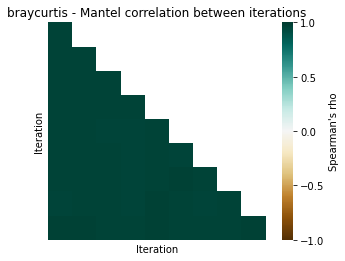

In [14]:
choices = ('matching', 'aitchison', 'euclidean', 'generalized_unifrac', 'canberra', 'russellrao', 'braycurtis', 'cosine', 'jensenshannon', 'yule', 'weighted_normalized_unifrac', 'unweighted_unifrac', 'hamming', 'weighted_unifrac', 'cityblock', 'sokalmichener', 'seuclidean', 'rogerstanimoto', 'correlation', 'minkowski', 'kulsinski', 'chebyshev', 'sqeuclidean', 'sokalsneath', 'jaccard', 'dice', 'canberra_adkins')
clustering_methods = ('nj', 'upgma')
correlation_methods = ('pearson', 'spearman')

sampling_depth = max(min_feature_count, 1)
metric = 'braycurtis'
clustering_method = clustering_methods[0]
correlation_method = correlation_methods[1]

beta_rar = beta_rarefaction(
    table = tabs,
    sampling_depth  = sampling_depth,
    metadata = metadata_qa,
    metric = metric,
    clustering_method = clustering_method,
    correlation_method = correlation_method,
)

 ## Beta diversity PCoA
 Ellipses represent 95% confidence intervals.

In [15]:
plot_tmp = f'{metric}-{clustering_method}-{correlation_method}-{sampling_depth}'
beta_rarefaction_view_path = os.path.join(qiime_folder, f'beta-rarefaction-{plot_tmp}.qzv')
beta_rar.visualization.save(beta_rarefaction_view_path)

beta_rar.visualization

<visualization: Visualization uuid: 7ab2e8f5-8089-4135-aabf-53317b63bfbc>